# Dual Motion Gan
Here is trying to implement the dual motion Gan on the weather data
We include the basic auto-encoder on this slides.

In [1]:
import tensorflow as tf
import cv2, random, os, time, math, pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Attributes


In [2]:
MODE = "NOGAN" ## "NOGAN" or "GAN"

chanels = 1

## enc/dec dims denotes the depth on Encodr-decoder model
enc_dims = [64,64*2,64*4]
dec_dims = [64,64*2,64*4]

learning_rate = "0.001"
optimizer_param = "0.5"

activation = tf.nn.relu

# here set the GPU be careful !!!!

changes the number as the GPU num

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# ops / utils

In [4]:
def add_activation_summary(var):
    tf.summary.histogram(var.op.name + "/activation", var)
    tf.summary.scalar(var.op.name + "/sparsity", tf.nn.zero_fraction(var))
    
def conv2d_strided(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding="SAME")
    return tf.nn.bias_add(conv, b)
    
def add_to_regularization_and_summary(var):
    if var is not None:
        tf.summary.histogram(var.op.name, var)
        tf.add_to_collection("reg_loss", tf.nn.l2_loss(var))
    
def weight_variable(shape, stddev=0.02, name=None):
    initial = tf.truncated_normal(shape, stddev=stddev)
    if name is None:
        return tf.Variable(initial)
    else:
        return tf.get_variable(name, initializer=initial)

def batch_norm(x, n_out, phase_train, scope='bn', decay=0.9, eps=1e-5, stddev=0.02):
    """
    Code taken from http://stackoverflow.com/a/34634291/2267819
    """
    with tf.variable_scope(scope)as scope2:
 
        
        beta = tf.get_variable(name='beta', shape=[n_out], initializer=tf.constant_initializer(0.0)
                               , trainable=True)
        gamma = tf.get_variable(name='gamma', shape=[n_out], initializer=tf.random_normal_initializer(1.0, stddev),
                                trainable=True)
        batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], name='moments')
        

        ema = tf.train.ExponentialMovingAverage(decay=decay)

        def mean_var_with_update():
            with tf.variable_scope(tf.get_variable_scope(), reuse=False):
                ema_apply_op = ema.apply([batch_mean, batch_var])
                with tf.control_dependencies([ema_apply_op]):
                
                    return tf.identity(batch_mean), tf.identity(batch_var)
        
        #if phase_train is not None:
        #    mean, var = mean_var_with_update()
        #else:
        #    mean = ema.average(batch_mean)
        #    var = ema.average(batch_var)
        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, eps)
    return normed

def conv2d_transpose_strided(x, W, b, output_shape=None):
    # print x.get_shape()
    # print W.get_shape()
    if output_shape is None:
        output_shape = x.get_shape().as_list()
        output_shape[1] *= 2
        output_shape[2] *= 2
        output_shape[3] = W.get_shape().as_list()[2]
    # print output_shape
    conv = tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, 2, 2, 1], padding="SAME")
    return tf.nn.bias_add(conv, b)

def bias_variable(shape, name=None):
    initial = tf.constant(0.0, shape=shape)
    if name is None:
        return tf.Variable(initial)
    else:
        return tf.get_variable(name, initializer=initial)


#utils.leaky_relu(x, alpha=0.2, name=name)
def leaky_relu(x, alpha=0.2, name=""):
    return tf.maximum(alpha * x, x, name)

def get_optimizer(optimizer_name, learning_rate, optimizer_param):
    if optimizer_name == "Adam":
        return tf.train.AdamOptimizer(learning_rate, beta1=optimizer_param)
    elif optimizer_name == "RMSProp":
        return tf.train.RMSPropOptimizer(learning_rate, decay=optimizer_param)
    else:
        raise ValueError("Unknown optimizer %s" % optimizer_name)
        
        
def add_gradient_summary(grad, var):
    if grad is not None:
        tf.summary.histogram(var.op.name + "/gradient", grad)
        
        
def visualization(input):
    with tf.Session() as sess:
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        sess.run(tf.initialize_all_variables())
        image = tf.cast(input,dtype=tf.int32)
        out = sess.run(image)
        coord.request_stop()
        coord.join(threads)
    #plt.imshow(out)
    return out

def log10(t):
    """
    Calculates the base-10 log of each element in t.
    @param t: The tensor from which to calculate the base-10 log.
    @return: A tensor with the base-10 log of each element in t.
    """

    numerator = tf.log(t)
    denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

# image_input

Here we consider image with 501*501 and 1 or 3 chanels
We consider raw data as groundtrth image and croping the image within the central here I consider 400*400 

Augument:
1. The chanels denotes the gray scale or the rgb scale

In [5]:
image_path = "/data1/weather1/my_data/r_1-20/TRAIN_001_r"
evaluate_image_path = "./data/train"
#def batch_input(image_path, times, batch_size, chanels=3, gap=5):
### TODO: pack it into function.

times = 6
batch_size = 2
gap = 5
upper_bound = 2000
image_folder = os.listdir(image_path)
filename_path = []
count = 0


for folder in image_folder:

    count = count +1
    if count==upper_bound:
        break

    if os.path.isdir(image_path+'/'+folder):
        filename_path.append(folder)

filename_tensor = tf.convert_to_tensor(filename_path)


file_name = image_path+ '/' + filename_tensor + '/' + filename_tensor +"_"
for i in range(times+1):
    index = "%03d"%(i*gap)

    locals()['filename_queue'+str(i)] = tf.train.string_input_producer(file_name + index + ".png", shuffle=False)
    locals()['reader'+str(i)] = tf.WholeFileReader()
    locals()['key'+str(i)], locals()['value'+str(i)] = locals()['reader'+str(i)].read(locals()['filename_queue'+str(i)])
    locals()['decodedimage'+str(i)]= tf.image.decode_png(locals()['value'+str(i)],channels=3)
    locals()['resized_image'+str(i)] = tf.image.resize_images(locals()['decodedimage'+str(i)], [128, 128]) 

    if chanels == 1:
        locals()['resized_image'+str(i)] = tf.image.rgb_to_grayscale(locals()['resized_image'+str(i)])

train_images = tf.stack([resized_image0,resized_image1,resized_image2,resized_image3,resized_image4,resized_image5])
label_images = resized_image6
print(train_images)

#key2, label_value = reader.read(label_filename_queue)
num_preprocess_threads = 4
num_examples_per_epoch = 800
train_image,label_image = tf.train.shuffle_batch([train_images, label_images], 2, 200, 100)


#return train_image, label_image ,train_key, label_key,train_filename,train_filename_queue


Tensor("stack:0", shape=(6, 128, 128, 1), dtype=float32)


# Visualizing the data input

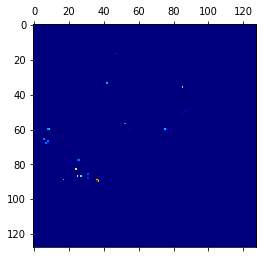

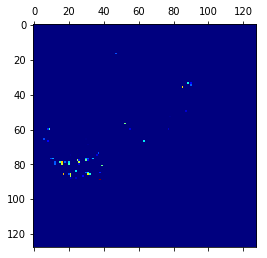

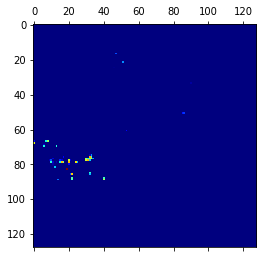

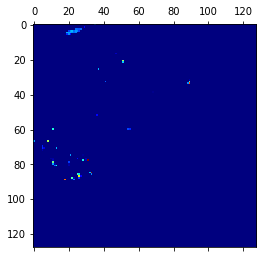

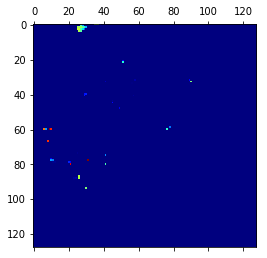

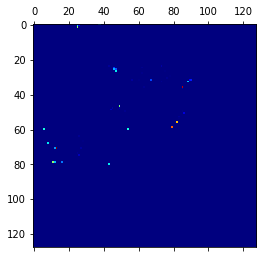

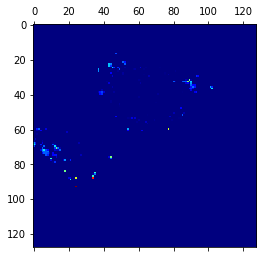

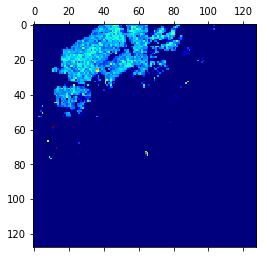

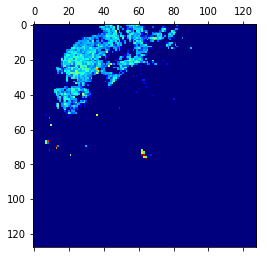

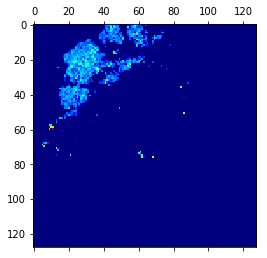

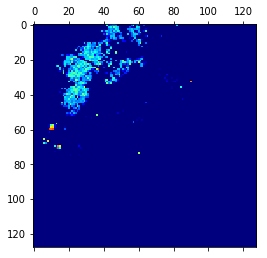

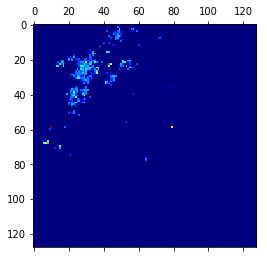

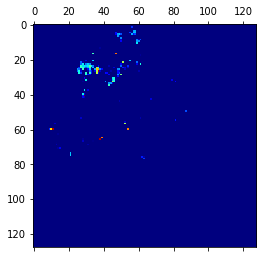

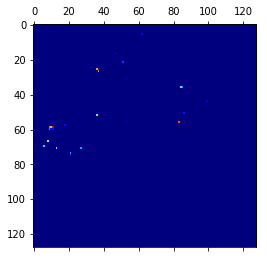

In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess, coord)

    for i in range(2):
        label_feed, label_feedd = sess.run([train_image,label_image])
        for j in range(6):
            plt.matshow(np.squeeze(label_feed[0], axis=(3,))[j], cmap=plt.cm.jet)
        plt.matshow(np.squeeze(label_feedd[0], axis=(2,)), cmap=plt.cm.jet)

    coord.request_stop()
    coord.join(threads)

# Evaluating

first input the evaluate test here
Simply loading the evaluate-image here may allow you to do evaluation easier.

In [7]:
def scal(image):
    for i in range(len(image)):
        for j in range(len(image[i])):
            if image[i,j][0]==255:
                image[i,j]= 0
                image[i,j]=int(image[i][j][0]*80/256)
    return image

imagelist = [] 
gtlist = []
gap = 5
image_path = evaluate_image_path
image_folder = os.listdir(evaluate_image_path)

for folder in image_folder:
    images = []
    gts = []
    print(folder)
    if os.path.isdir(image_path+"/"+folder):
        for i in range(61):
            if i % gap ==0 and i<30:
                index = "%03d"%i
                path = image_path+'/'+folder + '/' + folder +"_"+index + ".png"
                image = scal(cv2.imread(path))
                image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                image =cv2.resize(image,(128,128),interpolation=cv2.INTER_CUBIC)
                image = image[:,:,np.newaxis]
                images.append(image) 
            if i == 30:
                index = "%03d"%i
                path = image_path+'/'+folder + '/' + folder +"_"+index + ".png"
                image = scal(cv2.imread(path))
                image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                image =cv2.resize(image,(128,128),interpolation=cv2.INTER_CUBIC)
                image = image[:,:,np.newaxis]
                gts.append(image) 

        imagelist.append(images)
        gtlist.append(gts)


.DS_Store
RAD_206482424212532
RAD_206482424212533
RAD_206482424212531
RAD_206482424212535
RAD_206482424212534


# Model
## ConvLSTMVAE
Here is the encoder for the image taking the image size 
typically first layer have not change the image size

1. simplified the model with 128 input 
2. first layer 128*64
3. second 64*(64*2)
4. third 32*(64*4)

In [8]:
def ConvLSTMVAE(x, batch_size, enc_dims, dec_dims, times = 6,chanels = 3,
                activation = tf.nn.relu,scope_name = "ConvLSTMVAE",scope_reuse = False, normalize = False):
    
    N_enc = len(enc_dims)
    print(N_enc)
    with tf.variable_scope(scope_name) as scope:
        x_shape = x.get_shape().as_list()
        print(x_shape)
        if scope_reuse:
            print("resue")
            tf.get_variable_scope().reuse_variables()
            
        with tf.variable_scope("encoder") as scope:
            if normalize:
                h = tf.divide(x,255) # normalize the input from 0-255 to 0-1
                print(h)
            else:
                h = x 
            
            h = tf.reshape(h,[times*batch_size]+x_shape[2:])
            print(h)
            
            W = weight_variable(shape=[4,4,chanels,enc_dims[0]], name='W_init')
            b = bias_variable([enc_dims[0]], name="b_init")
            conv = tf.nn.conv2d(h, W, strides=[1, 1, 1, 1], padding="SAME")
            h_conv = tf.nn.bias_add(conv, b)
            h = activation(h_conv,name = "h_init")
            add_activation_summary(h)
            print(h)
            
            ### the loop for latent layers
            for index in range(N_enc-1):
                print(index)
                W = weight_variable(shape = [4,4,enc_dims[index],enc_dims[index+1]],name="W_%d"%index)
                b = bias_variable([enc_dims[index+1]], name="b_%d"%index)
                conv = conv2d_strided(h,W,b)
                h_bn = tf.contrib.layers.batch_norm(conv, decay = 0.9, epsilon=1e-5, scale=True, is_training=True, scope="gen_bn%d"%index)
                h = activation(h_bn,name="h_%d"%index)
                print(h)
                
        with tf.variable_scope("convlstmVAE") as scope:
            ### here stated the LSTM VAE part
            shape = h.get_shape().as_list()
            print("shape:")
            print(shape)
            featured_map = tf.reshape(h,[-1]+[times]+shape[1:])
            print(featured_map)
            Convlstmlayer=tf.contrib.rnn.ConvLSTMCell(conv_ndims = 2,input_shape = shape[1:],output_channels = shape[-1],kernel_shape=[5,5],forget_bias=1,name = "ConvLSTMCell")
            Convlstm_mu=tf.contrib.rnn.ConvLSTMCell(conv_ndims = 2,input_shape = shape[1:],output_channels = shape[-1],kernel_shape=[5,5],forget_bias=1,name = "ConvLSTMCell_mu")
            Convlstm_log_sigma=tf.contrib.rnn.ConvLSTMCell(conv_ndims = 2,input_shape = shape[1:],output_channels = shape[-1],kernel_shape=[5,5],forget_bias=1,name = "ConvLSTMCell_log_sigma")

            state = Convlstmlayer.zero_state(batch_size, dtype=tf.float32)
            state_mu = Convlstm_mu.zero_state(batch_size, dtype=tf.float32)
            state_log_sigma = Convlstm_log_sigma.zero_state(batch_size, dtype=tf.float32)
            
            #z_list = []
            for time_step in range(times):

                if time_step > 0: tf.get_variable_scope().reuse_variables()
                output,state =  (featured_map[:,time_step,:],state)
                print(output)
                output_mu,state_mu = Convlstm_mu(output,state_mu)
                output_log_sigma,state_log_sigma = Convlstm_log_sigma(output,state_log_sigma) 

            z_mu = output_mu
            z_log_sigma = 0.5 * output_log_sigma

            epsilon = tf.random_normal([batch_size,32,32,256])
            z = z_mu + tf.exp(z_log_sigma) * epsilon 
                #z_list.append(tf.expand_dims(z,1))

        size = shape[1]
        h = z
        print(h)
        #print(sampled_z)
        N_dec = len(dec_dims)
        
        with tf.variable_scope("decoder") as scope:
            for index in range(N_dec - 1):
                size *= 2
                W = weight_variable([4, 4, dec_dims[-index-2],dec_dims[-index -1]], name="W_%d" % index)
                b = tf.zeros([dec_dims[-index - 2]])
                deconv_shape = tf.stack([tf.shape(h)[0], size, size, dec_dims[-index - 2]])
                h_conv_t = conv2d_transpose_strided(h, W, b, output_shape=deconv_shape)
                #h_bn = batch_norm(h_conv_t, dims[index + 1], train_phase, scope="gen_bn%d" % index)
                h_bn = tf.contrib.layers.batch_norm(h_conv_t, decay = 0.9, epsilon=1e-5, scale=True, is_training=True, scope="disc_bn%d" % index)
                h = activation(h_bn, name='h_%d' % index)
                add_activation_summary(h)
                print(h)
                
            print(size)
            W_pred = weight_variable([5, 5, chanels, dec_dims[0]], name="W_pred")
            b = tf.zeros([chanels])
            deconv_shape = tf.stack([tf.shape(h)[0], size, size, chanels])

            h_conv_t = tf.nn.conv2d_transpose(h, W_pred, deconv_shape, strides=[1, 1, 1, 1], padding="SAME")
            tf.nn.bias_add(h_conv_t, b)
            #h_conv_t = conv2d_transpose_strided(h, W_pred, b, output_shape=deconv_shape)
            pred_image = activation(h_conv_t, name='pred_image')
            add_activation_summary(pred_image)
        
    return pred_image

        

# Model

Discriminator with the input corresponding to the dims
well in discriminator chanels are not consider since i fetch the size to the input

In [9]:
def discriminator(input_images,batch_size,activation=tf.nn.relu, scope_name="discriminator",
                   scope_reuse=False):
    shape = input_images.get_shape().as_list()
    N = int(math.log2(shape[1]/32))
    print(N)
    print(shape)
    
    with tf.variable_scope(scope_name) as scope:
        if scope_reuse:
            print("reuse")
            scope.reuse_variables()
            
        h = input_images
        skip_bn = True  # First layer of discriminator skips batch norm
        #image_size = input_images
        
        W = weight_variable([5, 5, shape[-1], 32], name="W_init1")
        b = bias_variable([32], name="b_init1")
        conv = tf.nn.conv2d(h, W, strides=[1, 1, 1, 1], padding="SAME")
        h_conv = tf.nn.bias_add(conv, b)
        h = activation(h_conv, name="h_init1")
        print(h)
        
        W = weight_variable([5, 5, 32, 64], name="W_init2")
        b = bias_variable([64], name="b_init2")
        conv = conv2d_strided(h, W, b)
        h = activation(conv, name="h_init2")
        print(h)
        skip_bn = True
        for index in range(N):

            W = weight_variable([5, 5, 64, 64], name="W_%d" % index)
            b = bias_variable([64], name="b_%d" % index)
            h_conv = conv2d_strided(h, W, b)
            if skip_bn:
                h_bn = h_conv
                skip_bn = False
            else:
                print("disc_bn%d" % index)
                #h_bn = batch_norm(h_conv, dims[index + 1], train_phase, scope="disc_bn%d" % index)
                h_bn = tf.contrib.layers.batch_norm(h_conv, decay = 0.9, epsilon=1e-5, scale=True, is_training=True, scope="disc_bn%d" % index)
            h = activation(h_bn, name="h_%d" % index)
            add_activation_summary(h)
            print(h)

        W = weight_variable([5, 5, 64, 1], name="W_end1")
        b = bias_variable([1], name="b_end1")
        conv = conv2d_strided(h, W, b)
        h = activation(conv, name="h_end1")
        
        shape = h.get_shape().as_list()
        
        print(h)
        h_reshaped = tf.reshape(h, [batch_size, 8 * 8 * 1])
        W_pred = weight_variable([8*8*1, 1], name="W_pred")
        b_pred = bias_variable([1], name="b_pred")
        h_pred = tf.matmul(h_reshaped, W_pred) + b_pred
 
        
    return tf.nn.sigmoid(h_pred), h_pred, h



# Loss Function
currently is the MSE as for testing

In [10]:
#norm_test = tf.divide(test,255)
def mse_loss(gen_image, test_image,generator_variables):
    mse = tf.losses.mean_squared_error(gen_image,test_image)
    tf.summary.scalar(mse.op.name + "/mse", mse)
    train_variables = tf.trainable_variables()

    adam = tf.train.AdamOptimizer()
    mse_loss = adam.minimize(mse,var_list = generator_variables)
    return mse_loss, mse

def gan_loss(logits_real, logits_fake, feature_real, feature_fake, use_features=False):
    discriminator_loss = tf.reduce_mean(logits_real - logits_fake)
    gen_loss = tf.reduce_mean(logits_fake)

    tf.summary.scalar("Discriminator_loss", discriminator_loss)
    tf.summary.scalar("Generator_loss", gen_loss)
    
    return gen_loss,discriminator_loss

# Setting up model

In [11]:

if MODE == "GAN":
    print("Setting up model with GAN")
    ##_setup_placehold
    train_shape = train_image.get_shape().as_list()
    test_shape = label_image.get_shape().as_list()
    train = tf.placeholder(tf.float32, shape=train_shape)
    test = tf.placeholder(tf.float32, shape=test_shape)
    
    gen_image = ConvLSTMVAE(train,2,enc_dims,dec_dims,chanels = chanels,scope_name = "generator")

    tf.summary.image("image_generated", gen_image)
    tf.summary.image("label_generated", test)

    discriminator_real_prob, logits_real, feature_real = discriminator(test, 2, activation=leaky_relu,
                                                                                     scope_name="discriminator",
                                                                                     scope_reuse=False)
    
    discriminator_fake_prob, logits_fake, feature_fake = discriminator(gen_image, 2, activation=leaky_relu,
                                                                                     scope_name="discriminator",
                                                                                     scope_reuse=True)
    
    GenLoss, DisLoss = gan_loss(logits_real, logits_fake, feature_real, feature_fake, use_features=True)
    train_variables = tf.trainable_variables() # EEE
    for v in train_variables:
        # print (v.op.name)
        add_to_regularization_and_summary(var=v)

    generator_variables = [v for v in train_variables if v.name.startswith("generator")]
    discriminator_variables = [v for v in train_variables if v.name.startswith("discriminator")]

    ##TODO get_optimizer bug
    #optim = get_optimizer("Adam", learning_rate, optimizer_param)
    
    adam = tf.train.AdamOptimizer()
    trainerD = adam.minimize(DisLoss, var_list=discriminator_variables)
    trainerG = adam.minimize(GenLoss, var_list=generator_variables)
    #generator_train_op = train(GenLoss, generator_variables, optim)
    #discriminator_train_op = train(DisLoss, discriminator_variables, optim)
    
else:
    print("Setting up model without GAN")
    ##_setup_placehold
    
    train_shape = train_image.get_shape().as_list()
    test_shape = label_image.get_shape().as_list()
    train = tf.placeholder(tf.float32, shape=train_shape)
    test = tf.placeholder(tf.float32, shape=test_shape)
    gen_image = ConvLSTMVAE(train,2,enc_dims,dec_dims,chanels = chanels,scope_name = "generator")
    eval_image = ConvLSTMVAE(train,2,enc_dims,dec_dims,chanels = chanels,scope_name = "generator",scope_reuse=True)
    
    tf.summary.image("image_test", test)
    tf.summary.image("image_generated", gen_image)

    train_variables = tf.trainable_variables() # EEE
    for v in train_variables:
        # print (v.op.name)
        add_to_regularization_and_summary(var=v)

    generator_variables = [v for v in train_variables if v.name.startswith("generator")]
    
    mse_loss,mse = mse_loss(gen_image, test,generator_variables)
    

Setting up model with GAN
3
[2, 6, 128, 128, 1]
Tensor("generator/encoder/Reshape:0", shape=(12, 128, 128, 1), dtype=float32)
Tensor("generator/encoder/h_init:0", shape=(12, 128, 128, 64), dtype=float32)
0
Tensor("generator/encoder/h_0:0", shape=(12, 64, 64, 128), dtype=float32)
1
Tensor("generator/encoder/h_1:0", shape=(12, 32, 32, 256), dtype=float32)
shape:
[12, 32, 32, 256]
Tensor("generator/convlstmVAE/Reshape:0", shape=(2, 6, 32, 32, 256), dtype=float32)
Tensor("generator/convlstmVAE/strided_slice:0", shape=(2, 32, 32, 256), dtype=float32)
Tensor("generator/convlstmVAE/strided_slice_1:0", shape=(2, 32, 32, 256), dtype=float32)
Tensor("generator/convlstmVAE/strided_slice_2:0", shape=(2, 32, 32, 256), dtype=float32)
Tensor("generator/convlstmVAE/strided_slice_3:0", shape=(2, 32, 32, 256), dtype=float32)
Tensor("generator/convlstmVAE/strided_slice_4:0", shape=(2, 32, 32, 256), dtype=float32)
Tensor("generator/convlstmVAE/strided_slice_5:0", shape=(2, 32, 32, 256), dtype=float32)
Ten

# Loading the model and summary

In [18]:
print("Initializing network...")
logs_dir = "logs/GAN/"
sess = tf.Session()
summary_op = tf.summary.merge_all()
saver = tf.train.Saver()
summary_writer = tf.summary.FileWriter(logs_dir, sess.graph)

sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state(logs_dir)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Model restored...")

Initializing network...


In [17]:
def evaluate(ops,sess,gt_im,ge_im):
    evaluate_im = np.array(imagelist[0:2])
    evaluate_img = sess.run(eval_image,feed_dict ={train:evaluate_im})
    print("evaluate_img")            
    mse_test = tf.losses.mean_squared_error(np.squeeze(evaluate_img, axis=(3,))[0],np.squeeze(gtlist[0], axis=(2,)))
    print(sess.run(mse_test))
    plt.matshow(np.squeeze(gtlist[0], axis=(2,)), cmap=plt.cm.jet)


# Traing on Testing 

In [19]:
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess, coord)
max_iterations = int(1e5)

## TODO: Timing....

def get_feed_dict(FLAG):
    if FLAG == "gen":
        feed_dict = {train:sess.run(train_image)}
    elif FLAG == "dis":
        label_feed,train_feed = sess.run([label_image,train_image])
        feed_dict = {test:label_feed,train:train_feed}
    elif FLAG == "noGAN":
        label_feed,train_feed = sess.run([label_image,train_image])
        feed_dict = {test:label_feed,train:train_feed}
    return feed_dict

if MODE == "NOGAN":
    print("Training Without GAN model...")
    try:

        for itr in range(1, max_iterations):
            feed_dict=get_feed_dict("noGAN")
            _,loss,ge_img, gt_image = sess.run([mse_loss,mse,gen_image,test,k1,k6],feed_dict = feed_dict)
            debug.append(ge_img)
            debug_gt.append(gt_image)
            print("num"+str(itr)+"mse_loss"+str(loss))
            if itr%100 ==0:
                summary = sess.run(summary_op,feed_dict = feed_dict)
                summary_writer.add_summary(summary,itr)

                evaluate_img = sess.run(eval_image,feed_dict ={train:evaluate_im})
                print("evaluate_img")            
                mse_test1 = tf.losses.mean_squared_error(np.squeeze(evaluate_img, axis=(3,))[0],np.squeeze(gtlist[0], axis=(3,))[0])
                mse_test2 = tf.losses.mean_squared_error(np.squeeze(evaluate_img, axis=(3,))[1],np.squeeze(gtlist[0], axis=(3,))[1])
                loss_t = sess.run(mse_test1)
                loss_t2 = sess.run(mse_test12)
                print("mse_test: "+str(loss_t))
                print("mse_test: "+str(loss_t2))

            if itr%2000 == 0:
                saver.save(sess, logs_dir + "model.ckpt", global_step=itr)
                #eva = evaluate(sess)
                #pickle.dump(eva, open("evaluat.pk", "wb"))
                #plt.imshow(eva[0][0])
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    except KeyboardInterrupt:
        print("Ending Training...")
    finally:
        saver.save(sess, logs_dir + "modelbroken.ckpt", global_step=itr)
        coord.request_stop()
        coord.join(threads)
        
elif MODE == "GAN":
    print("Training Wasserstein GAN model...")
    try:
        #clip_discriminator_var_op = [var.assign(tf.clip_by_value(var, clip_values[0], clip_values[1])) for
        #                             var in discriminator_variables]
        start_time = time.time()


        for itr in range(1, max_iterations):
            print(itr)
            if itr < 25 or itr % 500 == 0:
                critic_itrs = 25
            else:
                critic_itrs = critic_iterations

            for critic_itr in range(critic_itrs):
                sess.run(trainerD, feed_dict=get_feed_dict("dis"))
                #sess.run(clip_discriminator_var_op)

            feed_dict = get_feed_dict("dis")
            sess.run(trainerG, feed_dict=get_feed_dict("gen"))

            if itr % 100 == 0:
                summary_str = sess.run(summary_op, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, itr)

            if itr % 200 == 0:
                stop_time = time.time()
                duration = (stop_time - start_time) / 200.0
                start_time = stop_time
                g_loss_val, d_loss_val = sess.run([GenLoss, DisLoss],
                                                       feed_dict=get_feed_dict("dis"))
                print("Time: %g/itr, Step: %d, generator loss: %g, discriminator_loss: %g" % (
                    duration, itr, g_loss_val, d_loss_val))

            if itr % 5000 == 0:
                saver.save(sess, logs_dir + "model.ckpt", global_step=itr)

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    except KeyboardInterrupt:
        print("Ending Training...")
    finally:
        coord.request_stop()
        coord.join(threads)

Training Wasserstein GAN model...
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


NameError: name 'critic_iterations' is not defined

# Visualization & testing

In [22]:
evaluate_im = np.array(imagelist[0:2])
gtlist = np.array(gtlist[0:2])
evaluate_img = sess.run(eval_image,feed_dict ={train:evaluate_im})
evaluate_img = evaluate_img.astype(np.int8)

evalueate_img
34.063904
ge1
gt1
ge2
gt2


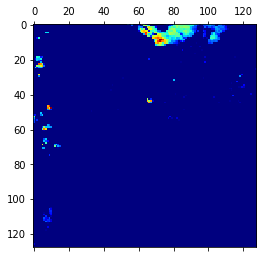

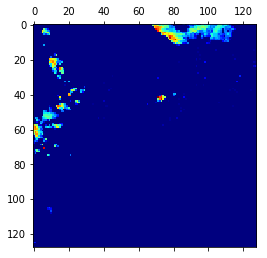

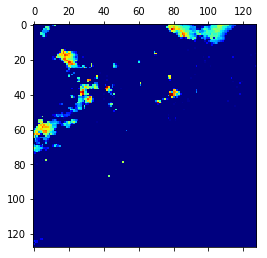

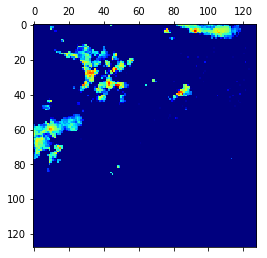

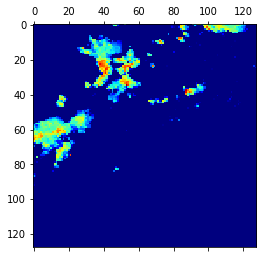

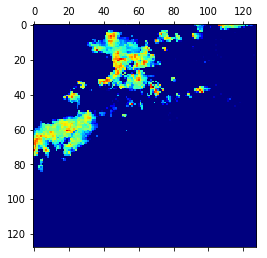

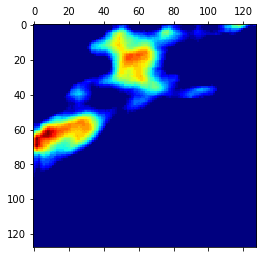

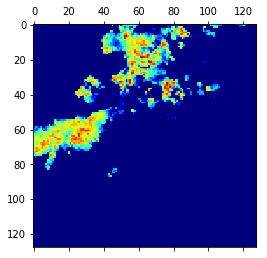

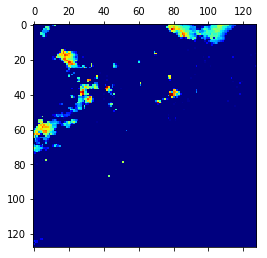

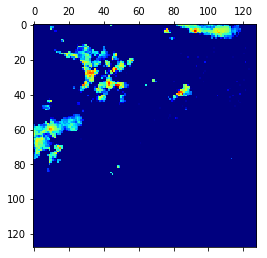

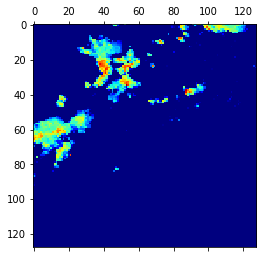

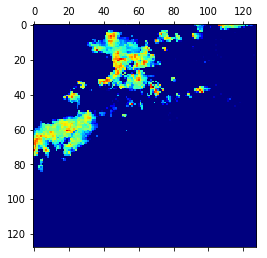

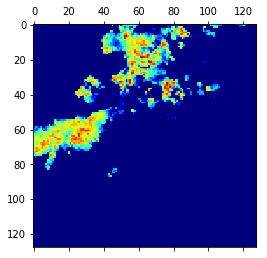

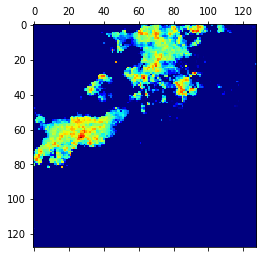

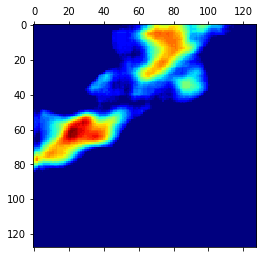

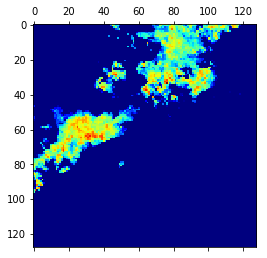

In [30]:
print("evalueate_img")            
mse_test = tf.losses.mean_squared_error(np.squeeze(evaluate_img, axis=(3,))[0],np.squeeze(gtlist[0], axis=(3,))[0])
print(sess.run(mse_test))
for i in range(6):
    plt.matshow(np.squeeze(evaluate_im[0], axis=(3,))[i], cmap=plt.cm.jet)
    
print("ge1")
plt.matshow(np.squeeze(evaluate_img, axis=(3,))[0], cmap=plt.cm.jet)
print("gt1")
plt.matshow(np.squeeze(gtlist[0], axis=(3,))[0], cmap=plt.cm.jet)
for i in range(6):
    plt.matshow(np.squeeze(evaluate_im[1], axis=(3,))[i], cmap=plt.cm.jet)
print("ge2")
plt.matshow(np.squeeze(evaluate_img, axis=(3,))[1], cmap=plt.cm.jet)
print("gt2")
plt.matshow(np.squeeze(gtlist[1], axis=(3,))[0], cmap=plt.cm.jet)

Text(0.5,1,'gen')

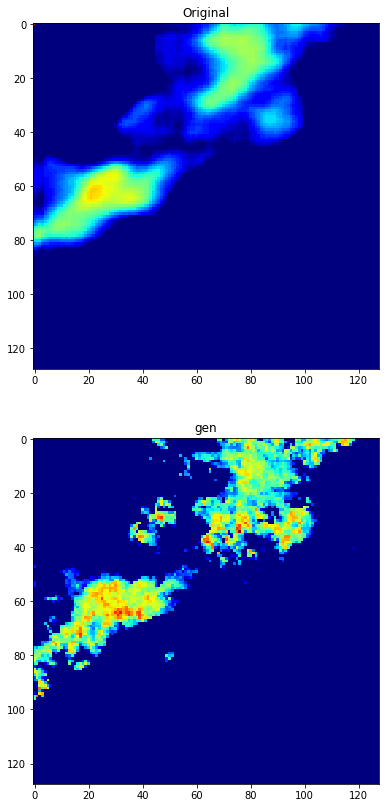

In [45]:
img =np.squeeze(evaluate_img, axis=(3,))[1]
img[0,0] = 55

fig, axes = plt.subplots(2, 1, figsize=(14, 14))
ax0, ax1 = axes.ravel()
ax0.imshow(img, cmap=plt.cm.jet)
ax0.set_title("Original")

ax1.imshow(np.squeeze(gtlist[1], axis=(3,))[0], cmap=plt.cm.jet)
ax1.set_title("gen")